# MIMIC-IV AKI Prediction: Model Training & Evaluation
#
**Purpose**: Train and evaluate multi-label classification models

**Input**: Preprocessed train/val/test splits from preprocessing notebook

**Output**: Trained models, performance metrics, visualizations
#
**Modeling Methods**:
 1. Logistic Regression (baseline)
 2. Random Forest
 3. XGBoost
 4. Multi-layer Perceptron (Neural Network)
#
**Validation**: ROC-AUC, PR-AUC, F1, Precision, Recall (per outcome + micro/macro avg)


### 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, roc_curve, 
    precision_recall_curve, classification_report,
    confusion_matrix, multilabel_confusion_matrix
)
import xgboost as xgb
import joblib
import warnings
import math
warnings.filterwarnings('ignore')

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

DATA_DIR = "./prediction_output/data"
RESULT_DIR = "./prediction_output/result"
MODEL_DIR = f"{RESULT_DIR}/models"
import os
os.makedirs(MODEL_DIR, exist_ok=True)

print("✓ Libraries loaded")


# Load preprocessed data
X_train = pd.read_csv(f"{DATA_DIR}/X_train.csv")
X_val = pd.read_csv(f"{DATA_DIR}/X_val.csv")
X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")

y_train = pd.read_csv(f"{DATA_DIR}/y_train.csv")
y_val = pd.read_csv(f"{DATA_DIR}/y_val.csv")
y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv")

target_cols = y_train.columns.tolist()

print(f"\n✓ Data loaded:")
print(f"  Train: X={X_train.shape}, y={y_train.shape}")
print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
print(f"  Test:  X={X_test.shape}, y={y_test.shape}")
print(f"\n  Features: {X_train.shape[1]}")
print(f"  Target variables: {target_cols}")

✓ Libraries loaded

✓ Data loaded:
  Train: X=(10775, 110), y=(10775, 4)
  Val:   X=(2309, 110), y=(2309, 4)
  Test:  X=(2310, 110), y=(2310, 4)

  Features: 110
  Target variables: ['severe_aki', 'progression', 'mortality', 'prolonged_icu']


In [2]:
list(X_train.columns)

['age',
 'chf',
 'hypertension',
 'diabetes',
 'ckd',
 'liver_disease',
 'copd',
 'malignancy',
 'mean_hr',
 'mean_map',
 'mean_map_inv',
 'mean_rr',
 'mean_temp',
 'min_hr',
 'min_map',
 'min_map_inv',
 'min_rr',
 'min_temp',
 'max_map',
 'max_rr',
 'max_temp',
 'mean_bun',
 'mean_cr',
 'mean_hco3',
 'mean_hgb',
 'mean_lactate',
 'mean_ph',
 'mean_plt',
 'mean_wbc',
 'min_hgb',
 'min_lactate',
 'min_ph',
 'max_lactate',
 'max_ph',
 'bun_cr_ratio',
 'cr_fold_change',
 'has_map_monitoring',
 'has_lactate',
 'has_bilirubin',
 'has_abg',
 'has_hemoglobin',
 'comorbidity_count',
 'hypotensive',
 'thrombocytopenia',
 'ICU_CCU',
 'ICU_ICU',
 'ICU_MICU',
 'ICU_MICU_SICU',
 'ICU_MED',
 'ICU_MED_CARD_INT',
 'ICU_NEURO_INT',
 'ICU_NEURO_SD',
 'ICU_NEURO_SICU',
 'ICU_PACU',
 'ICU_SURG_TRAUMA',
 'ICU_SURG_VASC_INT',
 'ICU_SICU',
 'ICU_TSICU',
 'gender_M',
 'race_ASIAN',
 'race_ASIAN - ASIAN INDIAN',
 'race_ASIAN - CHINESE',
 'race_ASIAN - KOREAN',
 'race_ASIAN - SOUTH EAST ASIAN',
 'race_BLACK/AFR

## 2. Define Evaluation Functions

In [3]:
print("Define Evaluation Functions")
print("="*60)

def evaluate_multilabel_model(y_true, y_pred_proba, model_name="Model"):
    """
    Comprehensive evaluation for multi-label classification
    
    Returns:
        results_df: DataFrame with metrics per outcome
        avg_metrics: Dictionary with micro/macro averages
    """
    results = []
    
    # Per-outcome metrics
    for i, outcome in enumerate(target_cols):
        y_true_outcome = y_true.iloc[:, i]
        y_pred_proba_outcome = y_pred_proba[:, i]
        y_pred_outcome = (y_pred_proba_outcome >= 0.5).astype(int)
        
        # Calculate metrics
        roc_auc = roc_auc_score(y_true_outcome, y_pred_proba_outcome)
        pr_auc = average_precision_score(y_true_outcome, y_pred_proba_outcome)
        f1 = f1_score(y_true_outcome, y_pred_outcome)
        precision = precision_score(y_true_outcome, y_pred_outcome, zero_division=0)
        recall = recall_score(y_true_outcome, y_pred_outcome, zero_division=0)
        
        results.append({
            'outcome': outcome,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        })
    
    results_df = pd.DataFrame(results)
    
    # Micro and macro averages
    y_pred_binary = (y_pred_proba >= 0.5).astype(int)
    
    avg_metrics = {
        'roc_auc_micro': roc_auc_score(y_true, y_pred_proba, average='micro'),
        'roc_auc_macro': roc_auc_score(y_true, y_pred_proba, average='macro'),
        'pr_auc_micro': average_precision_score(y_true, y_pred_proba, average='micro'),
        'pr_auc_macro': average_precision_score(y_true, y_pred_proba, average='macro'),
        'f1_micro': f1_score(y_true, y_pred_binary, average='micro'),
        'f1_macro': f1_score(y_true, y_pred_binary, average='macro'),
    }
    
    return results_df, avg_metrics


def print_evaluation_summary(results_df, avg_metrics, model_name, dataset_name):
    """Pretty print evaluation results"""
    print(f"\n{'='*60}")
    print(f"{model_name} - {dataset_name} Set")
    print(f"{'='*60}")
    
    print("\nPer-Outcome Metrics:")
    print(results_df.to_string(index=False))
    
    print(f"\n\nAverage Metrics:")
    print(f"  ROC-AUC  (micro): {avg_metrics['roc_auc_micro']:.4f}")
    print(f"  ROC-AUC  (macro): {avg_metrics['roc_auc_macro']:.4f}")
    print(f"  PR-AUC   (micro): {avg_metrics['pr_auc_micro']:.4f}")
    print(f"  PR-AUC   (macro): {avg_metrics['pr_auc_macro']:.4f}")
    print(f"  F1-score (micro): {avg_metrics['f1_micro']:.4f}")
    print(f"  F1-score (macro): {avg_metrics['f1_macro']:.4f}")


def plot_roc_curves(y_true, y_pred_proba, model_name, save_path):
    """Plot ROC curves for all outcomes"""
    n_targets = len(target_cols)
    n_cols = 4
    n_rows = math.ceil(n_targets / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 4 * n_rows)
    )
    axes = axes.flatten()
    
    for i, outcome in enumerate(target_cols):
        y_true_outcome = y_true.iloc[:, i]
        y_pred_proba_outcome = y_pred_proba[:, i]
        
        fpr, tpr, _ = roc_curve(y_true_outcome, y_pred_proba_outcome)
        roc_auc = roc_auc_score(y_true_outcome, y_pred_proba_outcome)
        
        axes[i].plot(fpr, tpr, color='darkorange', lw=2, 
                     label=f'ROC curve (AUC = {roc_auc:.3f})')
        axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate', fontsize=12)
        axes[i].set_ylabel('True Positive Rate', fontsize=12)
        axes[i].set_title(f'{outcome.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        axes[i].legend(loc="lower right")
        axes[i].grid(alpha=0.3)
    
    plt.suptitle(f'{model_name} - ROC Curves', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved ROC curves to {save_path}")


def plot_pr_curves(y_true, y_pred_proba, model_name, save_path):
    """Plot Precision-Recall curves for all outcomes"""
    n_targets = len(target_cols)
    n_cols = 4
    n_rows = math.ceil(n_targets / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 4 * n_rows)
    )
    axes = axes.flatten()
    
    for i, outcome in enumerate(target_cols):
        y_true_outcome = y_true.iloc[:, i]
        y_pred_proba_outcome = y_pred_proba[:, i]
        
        precision, recall, _ = precision_recall_curve(y_true_outcome, y_pred_proba_outcome)
        pr_auc = average_precision_score(y_true_outcome, y_pred_proba_outcome)
        baseline = y_true_outcome.mean()
        
        axes[i].plot(recall, precision, color='darkorange', lw=2,
                     label=f'PR curve (AUC = {pr_auc:.3f})')
        axes[i].axhline(y=baseline, color='navy', lw=2, linestyle='--',
                       label=f'Baseline ({baseline:.3f})')
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('Recall', fontsize=12)
        axes[i].set_ylabel('Precision', fontsize=12)
        axes[i].set_title(f'{outcome.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        axes[i].legend(loc="upper right")
        axes[i].grid(alpha=0.3)
    
    plt.suptitle(f'{model_name} - Precision-Recall Curves', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved PR curves to {save_path}")


print("✓ Evaluation functions defined")

Define Evaluation Functions
✓ Evaluation functions defined


## 3. Training
### Model 1: logistic regression with hyperparameter tuning

Model 1: logistic regression with hyperparameter tuning

Searching for best hyperparameters...
  Testing regularization strengths: 0.001, 0.01, 0.1, 1.0, 10.0

✓ Best parameters found:
  C = 0.1
  solver = lbfgs
  Validation ROC-AUC = 0.7905

Generating predictions with tuned model...

Logistic Regression (Tuned) - Validation Set

Per-Outcome Metrics:
      outcome  roc_auc   pr_auc       f1  precision   recall
   severe_aki 0.823864 0.830519 0.721506   0.744376 0.700000
  progression 0.853828 0.814853 0.683021   0.702523 0.664573
    mortality 0.779634 0.553478 0.562944   0.473398 0.694268
prolonged_icu 0.704816 0.489816 0.522619   0.440321 0.642753


Average Metrics:
  ROC-AUC  (micro): 0.7939
  ROC-AUC  (macro): 0.7905
  PR-AUC   (micro): 0.7184
  PR-AUC   (macro): 0.6722
  F1-score (micro): 0.6274
  F1-score (macro): 0.6225

Logistic Regression (Tuned) - Test Set

Per-Outcome Metrics:
      outcome  roc_auc   pr_auc       f1  precision   recall
   severe_aki 0.816221 0.825104 0.705

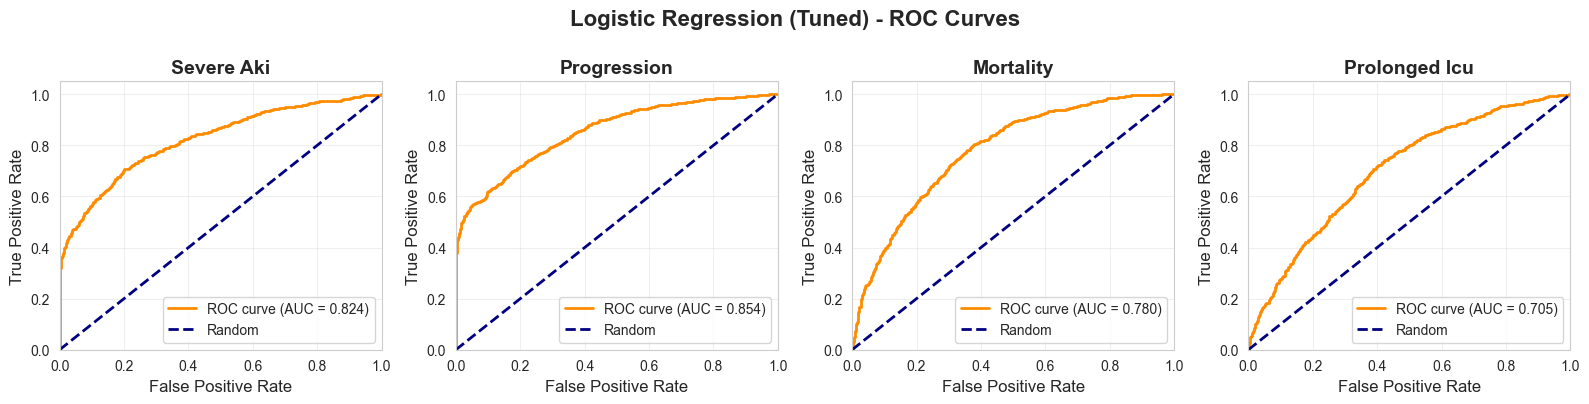

  ✓ Saved ROC curves to ./prediction_output/result/lr_roc_curves_val.png


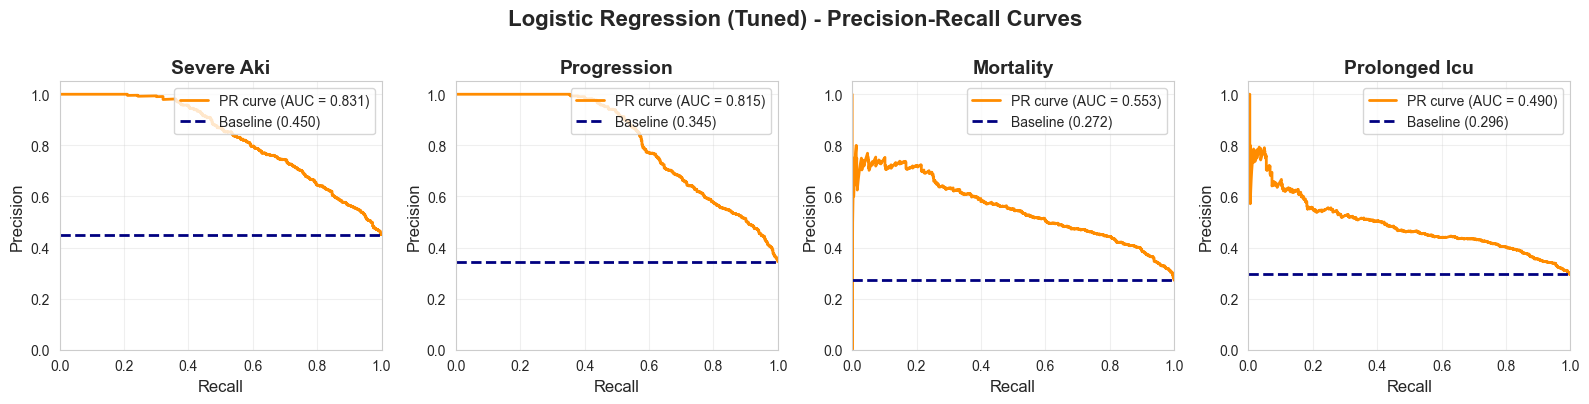

  ✓ Saved PR curves to ./prediction_output/result/lr_pr_curves_val.png

✓ Model saved to ./prediction_output/result/models/logistic_regression.pkl
✓ Best params saved to ./prediction_output/result/models/lr_best_params.pkl


In [4]:
print("Model 1: logistic regression with hyperparameter tuning")
print("="*60)

from sklearn.model_selection import GridSearchCV

print("\nSearching for best hyperparameters...")
print("  Testing regularization strengths: 0.001, 0.01, 0.1, 1.0, 10.0")

# Define parameter grid
lr_param_grid = {
    'estimator__C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'estimator__penalty': ['l2'],
    'estimator__solver': ['lbfgs', 'saga']
}

# Grid search on validation set
lr_base = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
)

best_lr_score = -1
best_lr_params = None
best_lr_model = None

# Manual grid search (GridSearchCV doesn't support MultiOutputClassifier well)
for C in [0.001, 0.01, 0.1, 1.0, 10.0]:
    for solver in ['lbfgs', 'saga']:
        lr_temp = MultiOutputClassifier(
            LogisticRegression(C=C, solver=solver, max_iter=1000, 
                             random_state=42, class_weight='balanced')
        )
        lr_temp.fit(X_train, y_train)
        
        y_val_pred_temp = lr_temp.predict_proba(X_val)
        y_val_pred_temp = np.array([estimator[:, 1] for estimator in y_val_pred_temp]).T
        
        val_score = roc_auc_score(y_val, y_val_pred_temp, average='macro')
        
        if val_score > best_lr_score:
            best_lr_score = val_score
            best_lr_params = {'C': C, 'solver': solver}
            best_lr_model = lr_temp

print(f"\n✓ Best parameters found:")
print(f"  C = {best_lr_params['C']}")
print(f"  solver = {best_lr_params['solver']}")
print(f"  Validation ROC-AUC = {best_lr_score:.4f}")

lr_model = best_lr_model

# Predictions with best model
print("\nGenerating predictions with tuned model...")
y_val_pred_lr = lr_model.predict_proba(X_val)
y_val_pred_lr = np.array([estimator[:, 1] for estimator in y_val_pred_lr]).T

y_test_pred_lr = lr_model.predict_proba(X_test)
y_test_pred_lr = np.array([estimator[:, 1] for estimator in y_test_pred_lr]).T

# Evaluate
val_results_lr, val_avg_lr = evaluate_multilabel_model(y_val, y_val_pred_lr, "Logistic Regression")
print_evaluation_summary(val_results_lr, val_avg_lr, "Logistic Regression (Tuned)", "Validation")

test_results_lr, test_avg_lr = evaluate_multilabel_model(y_test, y_test_pred_lr, "Logistic Regression")
print_evaluation_summary(test_results_lr, test_avg_lr, "Logistic Regression (Tuned)", "Test")

# Plots
plot_roc_curves(y_val, y_val_pred_lr, "Logistic Regression (Tuned)", 
                f"{RESULT_DIR}/lr_roc_curves_val.png")
plot_pr_curves(y_val, y_val_pred_lr, "Logistic Regression (Tuned)", 
               f"{RESULT_DIR}/lr_pr_curves_val.png")

# Save model and best params
joblib.dump(lr_model, f"{MODEL_DIR}/logistic_regression.pkl")
joblib.dump(best_lr_params, f"{MODEL_DIR}/lr_best_params.pkl")
print(f"\n✓ Model saved to {MODEL_DIR}/logistic_regression.pkl")
print(f"✓ Best params saved to {MODEL_DIR}/lr_best_params.pkl")

### Model 2: Random Forest 

MODEL 2: RANDOM FOREST WITH HYPERPARAMETER TUNING

Searching for best hyperparameters...
  This may take a few minutes...

  Testing 108 combinations
  [1/20] Testing: n_est=300, max_depth=15, min_split=5, min_leaf=2
      → New best! Val ROC-AUC = 0.8532
  [2/20] Testing: n_est=100, max_depth=15, min_split=10, min_leaf=10
  [3/20] Testing: n_est=100, max_depth=10, min_split=10, min_leaf=2
  [4/20] Testing: n_est=300, max_depth=20, min_split=10, min_leaf=5
  [5/20] Testing: n_est=100, max_depth=None, min_split=20, min_leaf=10
  [6/20] Testing: n_est=100, max_depth=None, min_split=10, min_leaf=5
  [7/20] Testing: n_est=100, max_depth=None, min_split=5, min_leaf=5
  [8/20] Testing: n_est=100, max_depth=15, min_split=20, min_leaf=10
  [9/20] Testing: n_est=100, max_depth=15, min_split=10, min_leaf=5
  [10/20] Testing: n_est=300, max_depth=15, min_split=10, min_leaf=10
  [11/20] Testing: n_est=200, max_depth=None, min_split=20, min_leaf=2
  [12/20] Testing: n_est=100, max_depth=15, min_spl

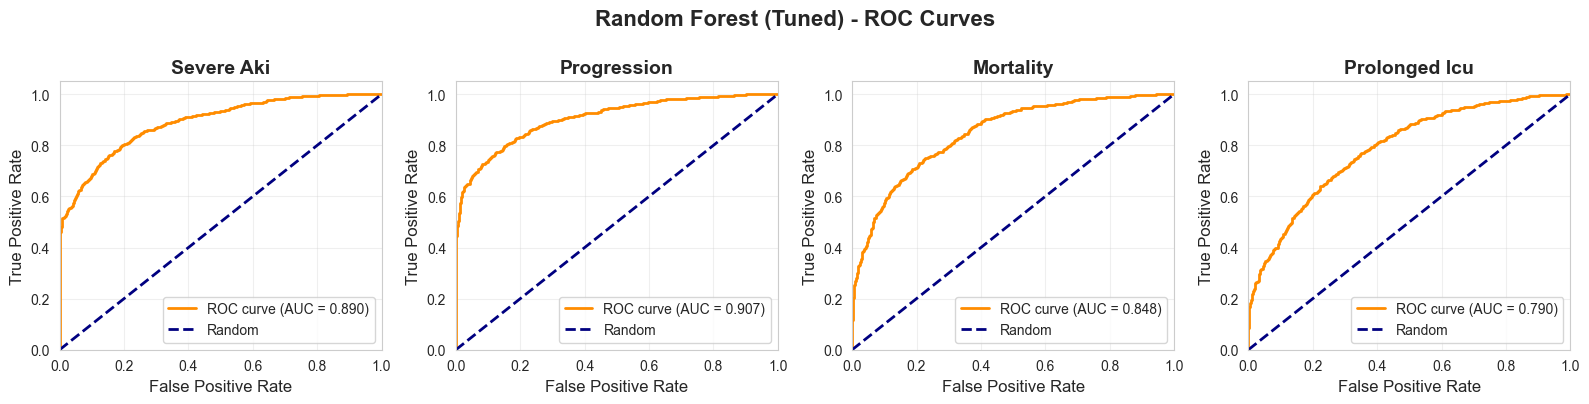

  ✓ Saved ROC curves to ./prediction_output/result/rf_roc_curves_val.png


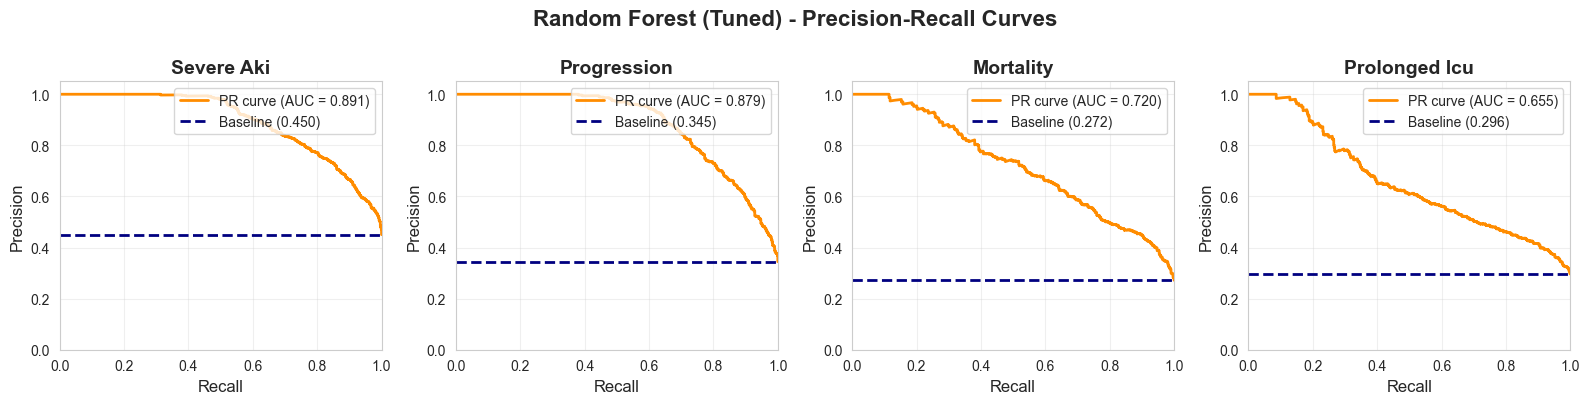

  ✓ Saved PR curves to ./prediction_output/result/rf_pr_curves_val.png
✓ Model saved to ./prediction_output/result/models/random_forest.pkl
✓ Best params saved to ./prediction_output/result/models/rf_best_params.pkl


In [5]:
print("MODEL 2: RANDOM FOREST WITH HYPERPARAMETER TUNING")
print("="*60)

print("\nSearching for best hyperparameters...")
print("  This may take a few minutes...")

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10]
}

print(f"\n  Testing {len(rf_param_grid['n_estimators']) * len(rf_param_grid['max_depth']) * len(rf_param_grid['min_samples_split']) * len(rf_param_grid['min_samples_leaf'])} combinations")

best_rf_score = -1
best_rf_params = None
best_rf_model = None

# Random search (faster than full grid)
from itertools import product
import random

# Sample 20 random combinations
param_combinations = list(product(
    rf_param_grid['n_estimators'],
    rf_param_grid['max_depth'],
    rf_param_grid['min_samples_split'],
    rf_param_grid['min_samples_leaf']
))
random.seed(42)
sampled_combinations = random.sample(param_combinations, min(20, len(param_combinations)))

for i, (n_est, max_d, min_split, min_leaf) in enumerate(sampled_combinations, 1):
    print(f"  [{i}/20] Testing: n_est={n_est}, max_depth={max_d}, min_split={min_split}, min_leaf={min_leaf}")
    
    rf_temp = MultiOutputClassifier(
        RandomForestClassifier(
            n_estimators=n_est,
            max_depth=max_d,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    )
    rf_temp.fit(X_train, y_train)
    
    y_val_pred_temp = rf_temp.predict_proba(X_val)
    y_val_pred_temp = np.array([estimator[:, 1] for estimator in y_val_pred_temp]).T
    
    val_score = roc_auc_score(y_val, y_val_pred_temp, average='macro')
    
    if val_score > best_rf_score:
        best_rf_score = val_score
        best_rf_params = {
            'n_estimators': n_est,
            'max_depth': max_d,
            'min_samples_split': min_split,
            'min_samples_leaf': min_leaf
        }
        best_rf_model = rf_temp
        print(f"      → New best! Val ROC-AUC = {val_score:.4f}")

print(f"\n✓ Best parameters found:")
for param, value in best_rf_params.items():
    print(f"  {param} = {value}")
print(f"  Validation ROC-AUC = {best_rf_score:.4f}")

rf_model = best_rf_model

# Predictions
print("\nGenerating predictions with tuned model...")
y_val_pred_rf = rf_model.predict_proba(X_val)
y_val_pred_rf = np.array([estimator[:, 1] for estimator in y_val_pred_rf]).T

y_test_pred_rf = rf_model.predict_proba(X_test)
y_test_pred_rf = np.array([estimator[:, 1] for estimator in y_test_pred_rf]).T

# Evaluate
val_results_rf, val_avg_rf = evaluate_multilabel_model(y_val, y_val_pred_rf, "Random Forest")
print_evaluation_summary(val_results_rf, val_avg_rf, "Random Forest (Tuned)", "Validation")

test_results_rf, test_avg_rf = evaluate_multilabel_model(y_test, y_test_pred_rf, "Random Forest")
print_evaluation_summary(test_results_rf, test_avg_rf, "Random Forest (Tuned)", "Test")

# Plots
plot_roc_curves(y_val, y_val_pred_rf, "Random Forest (Tuned)", 
                f"{RESULT_DIR}/rf_roc_curves_val.png")
plot_pr_curves(y_val, y_val_pred_rf, "Random Forest (Tuned)", 
               f"{RESULT_DIR}/rf_pr_curves_val.png")

# Save model and params
joblib.dump(rf_model, f"{MODEL_DIR}/random_forest.pkl")
joblib.dump(best_rf_params, f"{MODEL_DIR}/rf_best_params.pkl")
print(f"✓ Model saved to {MODEL_DIR}/random_forest.pkl")
print(f"✓ Best params saved to {MODEL_DIR}/rf_best_params.pkl")

### Model 3: XGBoost 

MODEL 3: XGBOOST WITH HYPERPARAMETER TUNING

Searching for best hyperparameters...
  This may take several minutes...

  Testing 15 random combinations per outcome

  Tuning model for severe_aki...
    Best params: n_est=300, max_depth=8, lr=0.05
    Validation ROC-AUC = 0.8842

  Tuning model for progression...
    Best params: n_est=200, max_depth=8, lr=0.1
    Validation ROC-AUC = 0.8997

  Tuning model for mortality...
    Best params: n_est=200, max_depth=8, lr=0.05
    Validation ROC-AUC = 0.8408

  Tuning model for prolonged_icu...
    Best params: n_est=100, max_depth=8, lr=0.1
    Validation ROC-AUC = 0.7788

✓ Tuning complete for all outcomes

XGBoost (Tuned) - Validation Set

Per-Outcome Metrics:
      outcome  roc_auc   pr_auc       f1  precision   recall
   severe_aki 0.884223 0.887887 0.761458   0.830682 0.702885
  progression 0.899745 0.875736 0.754902   0.852848 0.677136
    mortality 0.840777 0.683257 0.632831   0.630332 0.635350
prolonged_icu 0.778766 0.631366 0.57164

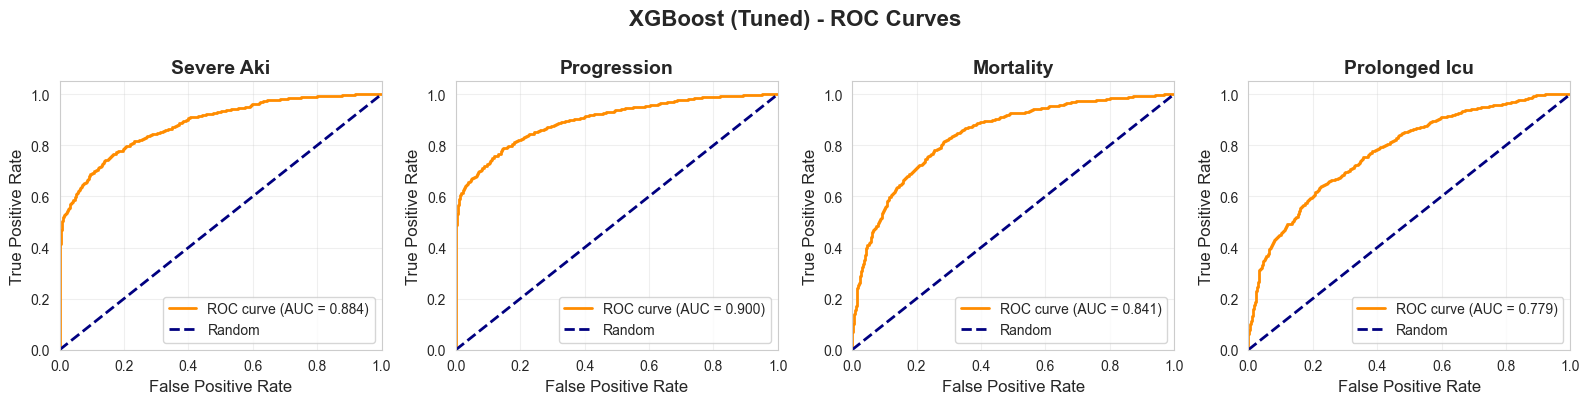

  ✓ Saved ROC curves to ./prediction_output/result/xgb_roc_curves_val.png


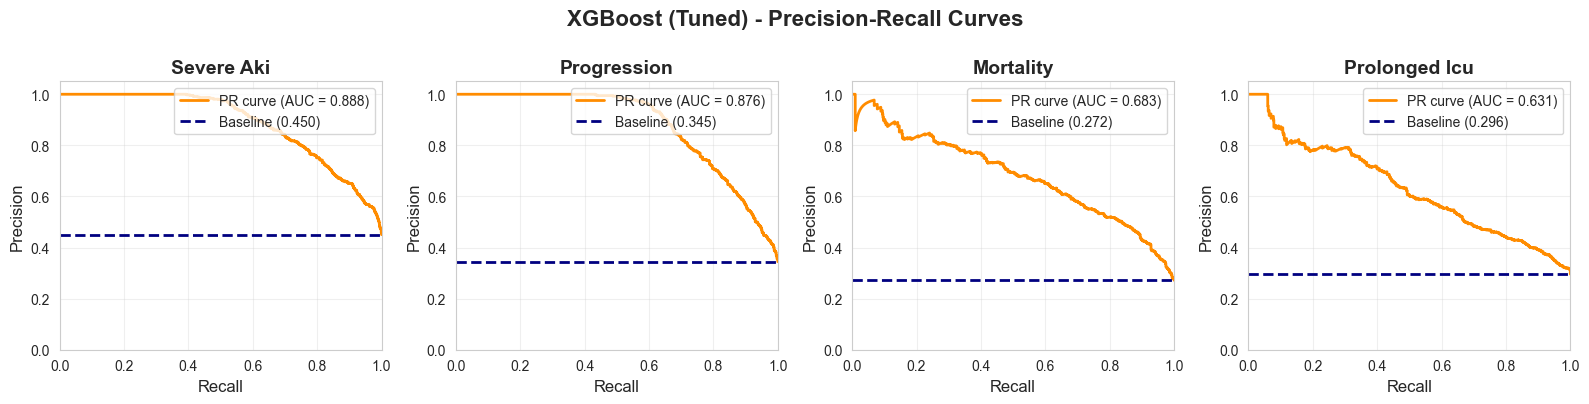

  ✓ Saved PR curves to ./prediction_output/result/xgb_pr_curves_val.png

Extracting feature importance...

Top 20 Most Important Features:
                                   feature  importance
                                   mean_cr    0.042241
                                   has_abg    0.033954
                             has_bilirubin    0.021954
                             liver_disease    0.021633
                 age_category_very_elderly    0.021125
                             ICU_NEURO_INT    0.016896
                            ICU_NEURO_SICU    0.016658
                            cr_fold_change    0.016461
admission_type_SURGICAL SAME DAY ADMISSION    0.015140
                               has_lactate    0.014885
                                  ICU_MICU    0.014805
         admission_location_PROCEDURE SITE    0.014282
                                 ICU_TSICU    0.013504
                             ICU_MICU_SICU    0.013256
                   admission_type_EL

In [ ]:
print("MODEL 3: XGBOOST WITH HYPERPARAMETER TUNING")
print("="*60)

print("\nSearching for best hyperparameters...")
print("  This may take several minutes...")

# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Sample combinations for each outcome
print(f"\n  Testing 15 random combinations per outcome")

best_xgb_models = []
best_xgb_params_list = []
y_val_pred_xgb = np.zeros((len(X_val), len(target_cols)))
y_test_pred_xgb = np.zeros((len(X_test), len(target_cols)))

for i, outcome in enumerate(target_cols):
    print(f"\n  Tuning model for {outcome}...")
    
    # Calculate scale_pos_weight
    neg_count = (y_train.iloc[:, i] == 0).sum()
    pos_count = (y_train.iloc[:, i] == 1).sum()
    scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
    
    # Sample parameter combinations
    param_combinations = list(product(
        xgb_param_grid['n_estimators'],
        xgb_param_grid['max_depth'],
        xgb_param_grid['learning_rate'],
        xgb_param_grid['subsample'],
        xgb_param_grid['colsample_bytree']
    ))
    random.seed(42 + i)
    sampled_combinations = random.sample(param_combinations, min(15, len(param_combinations)))
    
    best_score = -1
    best_params = None
    best_model = None
    
    for j, (n_est, max_d, lr, subsample, colsample) in enumerate(sampled_combinations, 1):
        xgb_temp = xgb.XGBClassifier(
            n_estimators=n_est,
            max_depth=max_d,
            learning_rate=lr,
            subsample=subsample,
            colsample_bytree=colsample,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss',
            tree_method='hist'
        )
        
        xgb_temp.fit(X_train, y_train.iloc[:, i])
        y_val_pred_temp = xgb_temp.predict_proba(X_val)[:, 1]
        val_score = roc_auc_score(y_val.iloc[:, i], y_val_pred_temp)
        
        if val_score > best_score:
            best_score = val_score
            best_params = {
                'n_estimators': n_est,
                'max_depth': max_d,
                'learning_rate': lr,
                'subsample': subsample,
                'colsample_bytree': colsample
            }
            best_model = xgb_temp
    
    print(f"    Best params: n_est={best_params['n_estimators']}, max_depth={best_params['max_depth']}, lr={best_params['learning_rate']}")
    print(f"    Validation ROC-AUC = {best_score:.4f}")
    
    best_xgb_models.append(best_model)
    best_xgb_params_list.append(best_params)
    
    y_val_pred_xgb[:, i] = best_model.predict_proba(X_val)[:, 1]
    y_test_pred_xgb[:, i] = best_model.predict_proba(X_test)[:, 1]

print("\n✓ Tuning complete for all outcomes")

# Evaluate
val_results_xgb, val_avg_xgb = evaluate_multilabel_model(y_val, y_val_pred_xgb, "XGBoost")
print_evaluation_summary(val_results_xgb, val_avg_xgb, "XGBoost (Tuned)", "Validation")

test_results_xgb, test_avg_xgb = evaluate_multilabel_model(y_test, y_test_pred_xgb, "XGBoost")
print_evaluation_summary(test_results_xgb, test_avg_xgb, "XGBoost (Tuned)", "Test")

# Plots
plot_roc_curves(y_val, y_val_pred_xgb, "XGBoost (Tuned)", 
                f"{RESULT_DIR}/xgb_roc_curves_val.png")
plot_pr_curves(y_val, y_val_pred_xgb, "XGBoost (Tuned)", 
               f"{RESULT_DIR}/xgb_pr_curves_val.png")

# Feature importance
print("\nExtracting feature importance...")
xgb_importance = np.zeros(X_train.shape[1])
for model in best_xgb_models:
    xgb_importance += model.feature_importances_
xgb_importance /= len(best_xgb_models)

xgb_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(xgb_importance_df.head(20).to_string(index=False))

# Save models and params
joblib.dump(best_xgb_models, f"{MODEL_DIR}/xgb_models.pkl")
joblib.dump(best_xgb_params_list, f"{MODEL_DIR}/xgb_best_params.pkl")
xgb_importance_df.to_csv(f"{RESULT_DIR}/xgb_feature_importance.csv", index=False)
print(f"\n✓ Models saved to {MODEL_DIR}/xgb_models.pkl")
print(f"✓ Best params saved to {MODEL_DIR}/xgb_best_params.pkl")

### Model 4: multi-layer perceptron 

MODEL 4: MULTI-LAYER PERCEPTRON WITH HYPERPARAMETER TUNING

Searching for best hyperparameters...
  Testing 18 combinations
  Testing: layers=(128, 64), lr=0.001, alpha=0.0001
      → New best! Val ROC-AUC = 0.7957
  Testing: layers=(128, 64), lr=0.001, alpha=0.001
      → New best! Val ROC-AUC = 0.8053
  Testing: layers=(128, 64), lr=0.001, alpha=0.01
  Testing: layers=(128, 64), lr=0.01, alpha=0.0001
  Testing: layers=(128, 64), lr=0.01, alpha=0.001
  Testing: layers=(128, 64), lr=0.01, alpha=0.01
  Testing: layers=(128, 64, 32), lr=0.001, alpha=0.0001
  Testing: layers=(128, 64, 32), lr=0.001, alpha=0.001
  Testing: layers=(128, 64, 32), lr=0.001, alpha=0.01
  Testing: layers=(128, 64, 32), lr=0.01, alpha=0.0001
  Testing: layers=(128, 64, 32), lr=0.01, alpha=0.001
  Testing: layers=(128, 64, 32), lr=0.01, alpha=0.01
  Testing: layers=(256, 128, 64), lr=0.001, alpha=0.0001
  Testing: layers=(256, 128, 64), lr=0.001, alpha=0.001
  Testing: layers=(256, 128, 64), lr=0.001, alpha=0.01


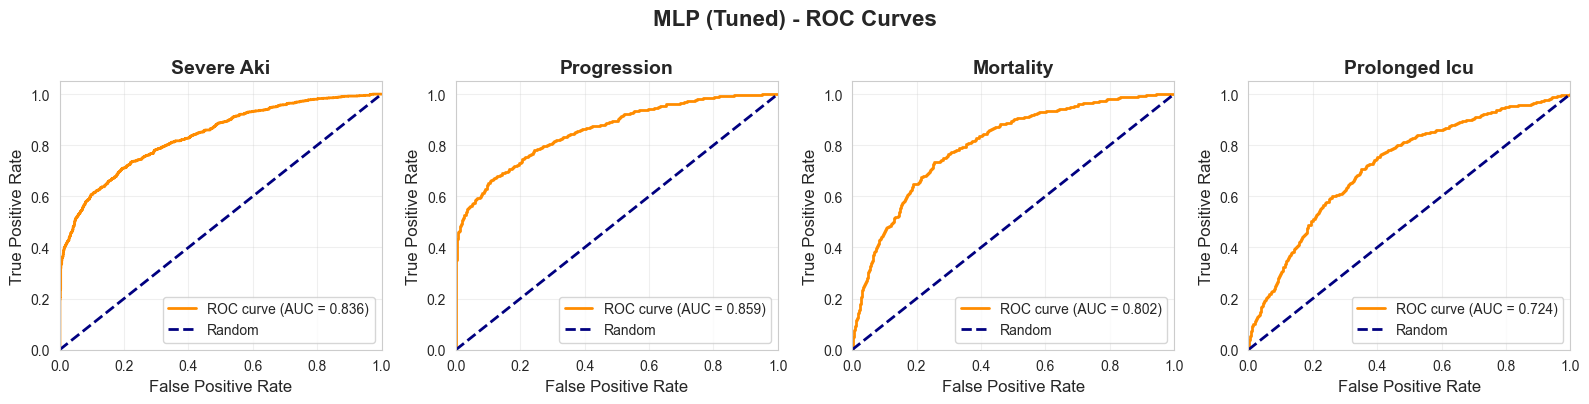

  ✓ Saved ROC curves to ./prediction_output/result/mlp_roc_curves_val.png


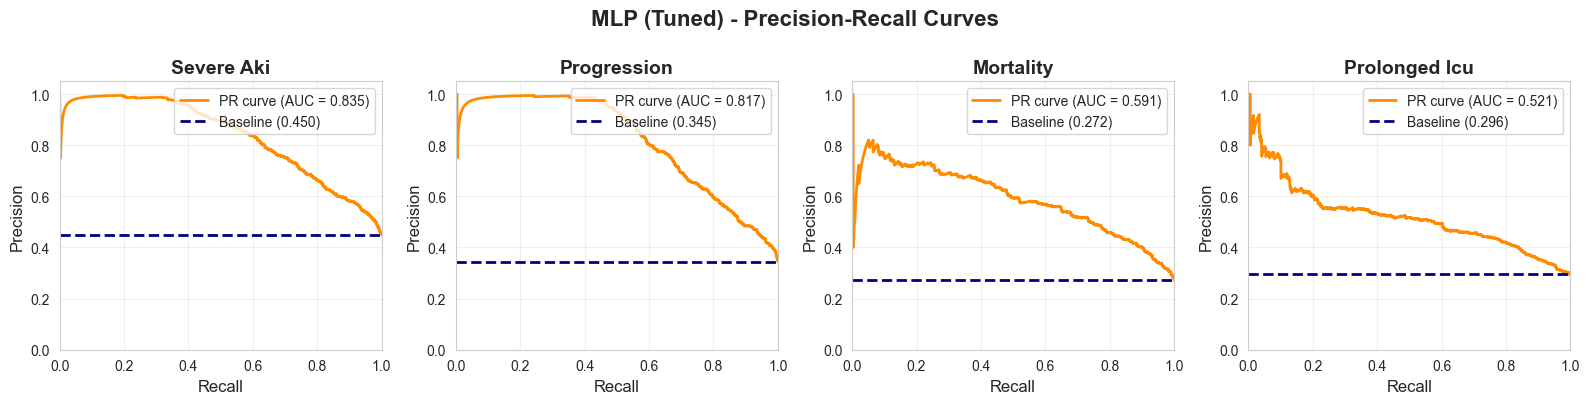

  ✓ Saved PR curves to ./prediction_output/result/mlp_pr_curves_val.png

✓ Model saved to ./prediction_output/result/models/mlp.pkl
✓ Best params saved to ./prediction_output/result/models/mlp_best_params.pkl


In [7]:
print("MODEL 4: MULTI-LAYER PERCEPTRON WITH HYPERPARAMETER TUNING")
print("="*60)

print("\nSearching for best hyperparameters...")

# Define parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(128, 64), (128, 64, 32), (256, 128, 64)],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01]  # L2 regularization
}

print(f"  Testing {len(mlp_param_grid['hidden_layer_sizes']) * len(mlp_param_grid['learning_rate_init']) * len(mlp_param_grid['alpha'])} combinations")

best_mlp_score = -1
best_mlp_params = None
best_mlp_model = None

for hidden_layers in mlp_param_grid['hidden_layer_sizes']:
    for lr_init in mlp_param_grid['learning_rate_init']:
        for alpha in mlp_param_grid['alpha']:
            print(f"  Testing: layers={hidden_layers}, lr={lr_init}, alpha={alpha}")
            
            mlp_temp = MultiOutputClassifier(
                MLPClassifier(
                    hidden_layer_sizes=hidden_layers,
                    activation='relu',
                    solver='adam',
                    learning_rate_init=lr_init,
                    alpha=alpha,
                    max_iter=300,
                    early_stopping=True,
                    validation_fraction=0.1,
                    random_state=42
                )
            )
            mlp_temp.fit(X_train, y_train)
            
            y_val_pred_temp = mlp_temp.predict_proba(X_val)
            y_val_pred_temp = np.array([estimator[:, 1] for estimator in y_val_pred_temp]).T
            
            val_score = roc_auc_score(y_val, y_val_pred_temp, average='macro')
            
            if val_score > best_mlp_score:
                best_mlp_score = val_score
                best_mlp_params = {
                    'hidden_layer_sizes': hidden_layers,
                    'learning_rate_init': lr_init,
                    'alpha': alpha
                }
                best_mlp_model = mlp_temp
                print(f"      → New best! Val ROC-AUC = {val_score:.4f}")

print(f"\n✓ Best parameters found:")
for param, value in best_mlp_params.items():
    print(f"  {param} = {value}")
print(f"  Validation ROC-AUC = {best_mlp_score:.4f}")

mlp_model = best_mlp_model

# Predictions
print("\nGenerating predictions with tuned model...")
y_val_pred_mlp = mlp_model.predict_proba(X_val)
y_val_pred_mlp = np.array([estimator[:, 1] for estimator in y_val_pred_mlp]).T

y_test_pred_mlp = mlp_model.predict_proba(X_test)
y_test_pred_mlp = np.array([estimator[:, 1] for estimator in y_test_pred_mlp]).T

# Evaluate
val_results_mlp, val_avg_mlp = evaluate_multilabel_model(y_val, y_val_pred_mlp, "MLP")
print_evaluation_summary(val_results_mlp, val_avg_mlp, "MLP (Tuned)", "Validation")

test_results_mlp, test_avg_mlp = evaluate_multilabel_model(y_test, y_test_pred_mlp, "MLP")
print_evaluation_summary(test_results_mlp, test_avg_mlp, "MLP (Tuned)", "Test")

# Plots
plot_roc_curves(y_val, y_val_pred_mlp, "MLP (Tuned)", 
                f"{RESULT_DIR}/mlp_roc_curves_val.png")
plot_pr_curves(y_val, y_val_pred_mlp, "MLP (Tuned)", 
               f"{RESULT_DIR}/mlp_pr_curves_val.png")

# Save model and params
joblib.dump(mlp_model, f"{MODEL_DIR}/mlp.pkl")
joblib.dump(best_mlp_params, f"{MODEL_DIR}/mlp_best_params.pkl")
print(f"\n✓ Model saved to {MODEL_DIR}/mlp.pkl")
print(f"✓ Best params saved to {MODEL_DIR}/mlp_best_params.pkl")

## 4. Model Comparison

MODEL COMPARISON

Model Comparison (Macro-Averaged Metrics):
                      Model  Val_ROC_AUC  Val_PR_AUC   Val_F1  Test_ROC_AUC  Test_PR_AUC  Test_F1
Logistic Regression (Tuned)     0.790536    0.672167 0.622523      0.775897     0.658787 0.608964
      Random Forest (Tuned)     0.858707    0.786426 0.629385      0.847595     0.773528 0.621828
            XGBoost (Tuned)     0.850878    0.769561 0.680208      0.842114     0.756584 0.676010
                MLP (Tuned)     0.805262    0.691177 0.584836      0.801247     0.689856 0.585147

✓ Comparison saved to ./prediction_output/result/model_comparison.csv


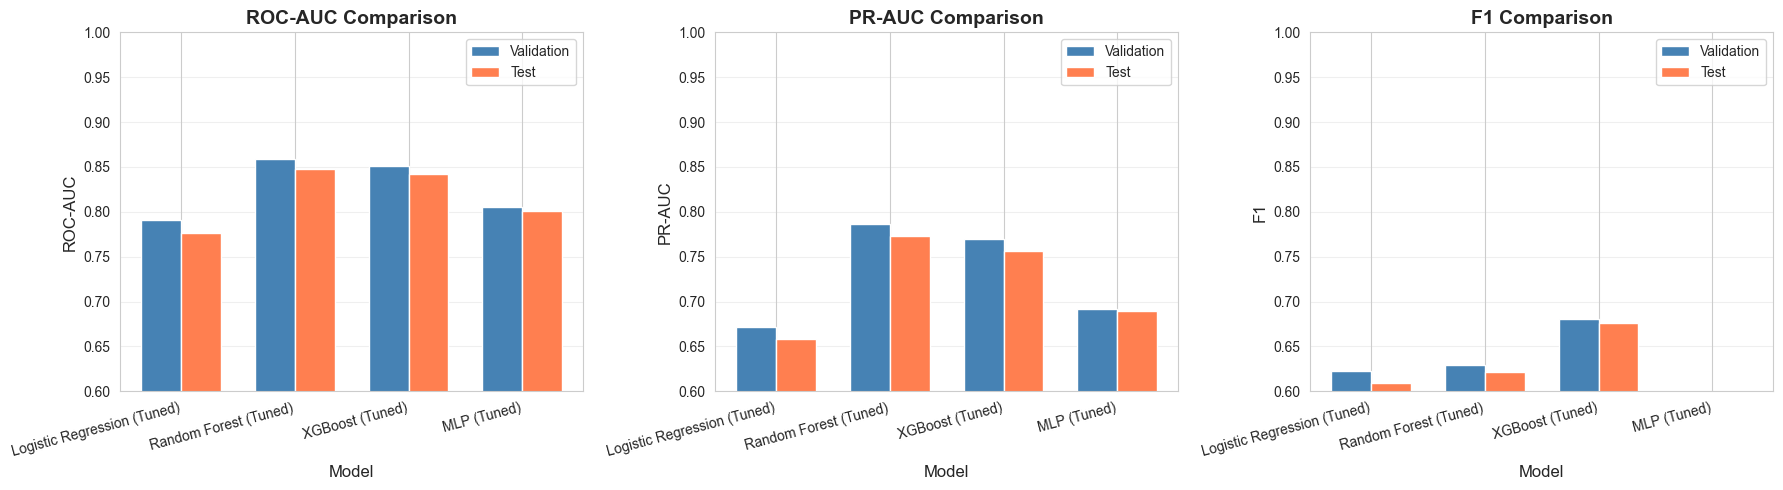

✓ Comparison plot saved to ./prediction_output/result/model_comparison_plot.png


In [8]:
print("MODEL COMPARISON")
print("="*60)

# Compile results
comparison_results = []

models_data = [
    ("Logistic Regression (Tuned)", val_avg_lr, test_avg_lr),
    ("Random Forest (Tuned)", val_avg_rf, test_avg_rf),
    ("XGBoost (Tuned)", val_avg_xgb, test_avg_xgb),
    ("MLP (Tuned)", val_avg_mlp, test_avg_mlp)
]

for model_name, val_metrics, test_metrics in models_data:
    comparison_results.append({
        'Model': model_name,
        'Val_ROC_AUC': val_metrics['roc_auc_macro'],
        'Val_PR_AUC': val_metrics['pr_auc_macro'],
        'Val_F1': val_metrics['f1_macro'],
        'Test_ROC_AUC': test_metrics['roc_auc_macro'],
        'Test_PR_AUC': test_metrics['pr_auc_macro'],
        'Test_F1': test_metrics['f1_macro']
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nModel Comparison (Macro-Averaged Metrics):")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv(f"{RESULT_DIR}/model_comparison.csv", index=False)
print(f"\n✓ Comparison saved to {RESULT_DIR}/model_comparison.csv")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['ROC_AUC', 'PR_AUC', 'F1']
colors = ['steelblue', 'coral']

for idx, metric in enumerate(metrics):
    val_col = f'Val_{metric}'
    test_col = f'Test_{metric}'
    
    x = np.arange(len(comparison_df))
    width = 0.35
    
    axes[idx].bar(x - width/2, comparison_df[val_col], width, 
                  label='Validation', color=colors[0])
    axes[idx].bar(x + width/2, comparison_df[test_col], width, 
                  label='Test', color=colors[1])
    
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel(metric.replace('_', '-'), fontsize=12)
    axes[idx].set_title(f'{metric.replace("_", "-")} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0.6, 1.0])

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/model_comparison_plot.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Comparison plot saved to {RESULT_DIR}/model_comparison_plot.png")


## 5. Best Model Final Evaluation

In [9]:
print("BEST MODEL FINAL EVALUATION")
print("="*60)

# Select best model based on validation ROC-AUC
best_idx = comparison_df['Val_ROC_AUC'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Validation ROC-AUC: {comparison_df.loc[best_idx, 'Val_ROC_AUC']:.4f}")
print(f"   Test ROC-AUC:       {comparison_df.loc[best_idx, 'Test_ROC_AUC']:.4f}")

# Get best model predictions
model_predictions = {
    "Logistic Regression (Tuned)": (y_test_pred_lr, lr_model),
    "Random Forest (Tuned)": (y_test_pred_rf, rf_model),
    "XGBoost (Tuned)": (y_test_pred_xgb, best_xgb_models),
    "MLP (Tuned)": (y_test_pred_mlp, mlp_model)
}

best_pred, best_model = model_predictions[best_model_name]

# Detailed per-outcome evaluation

print(f"DETAILED TEST SET EVALUATION - {best_model_name}")
print("="*60)

for i, outcome in enumerate(target_cols):
    y_true_outcome = y_test.iloc[:, i]
    y_pred_proba_outcome = best_pred[:, i]
    y_pred_outcome = (y_pred_proba_outcome >= 0.5).astype(int)
    
    print(f"\n{outcome.upper().replace('_', ' ')}")
    print("-" * 60)
    print(classification_report(y_true_outcome, y_pred_outcome, 
                                target_names=['No', 'Yes'], digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true_outcome, y_pred_outcome)
    print(f"\nConfusion Matrix:")
    print(f"                Predicted No    Predicted Yes")
    print(f"Actual No       {cm[0,0]:8d}        {cm[0,1]:8d}")
    print(f"Actual Yes      {cm[1,0]:8d}        {cm[1,1]:8d}")

BEST MODEL FINAL EVALUATION

🏆 Best Model: Random Forest (Tuned)
   Validation ROC-AUC: 0.8587
   Test ROC-AUC:       0.8476
DETAILED TEST SET EVALUATION - Random Forest (Tuned)

SEVERE AKI
------------------------------------------------------------
              precision    recall  f1-score   support

          No     0.7615    0.9228    0.8345      1270
         Yes     0.8729    0.6471    0.7432      1040

    accuracy                         0.7987      2310
   macro avg     0.8172    0.7850    0.7888      2310
weighted avg     0.8117    0.7987    0.7934      2310


Confusion Matrix:
                Predicted No    Predicted Yes
Actual No           1172              98
Actual Yes           367             673

PROGRESSION
------------------------------------------------------------
              precision    recall  f1-score   support

          No     0.8381    0.9781    0.9027      1556
         Yes     0.9312    0.6101    0.7372       754

    accuracy                         

In [10]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Create output directory
os.makedirs('./output/interpretation', exist_ok=True)

# 1. Prepare a sample for SHAP
X_sample = X_test.sample(min(1000, len(X_test)), random_state=42)

print(f"🔍 Starting global interpretation for {len(target_cols)} targets...")
print("="*75)

for i, target_name in enumerate(target_cols):
    print(f"\n🎯 TARGET: {target_name.upper()}")
    model_to_interpret = best_model.estimators_[i]
    
    # Text Output
    feat_importances = pd.Series(model_to_interpret.feature_importances_, index=X_test.columns)
    print(f"\nTop 10 Important Features (by Gain):")
    for rank, (name, score) in enumerate(feat_importances.nlargest(10).items(), 1):
        print(f"  {rank}. {name:25} (Score: {score:.4f})")

    # SHAP Calculation
    explainer = shap.TreeExplainer(model_to_interpret)
    explanation = explainer(X_sample)

    # Slice for positive class if 3D
    if len(explanation.values.shape) == 3:
        shap_values_2d = explanation[:, :, 1]
    else:
        shap_values_2d = explanation

    # --- Visualizations (CREATE EACH SEPARATELY) ---
    
    # 1. Bar Chart (Gain) - Height 8
    fig1, ax1 = plt.subplots(figsize=(16, 8))
    feat_importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='steelblue', ax=ax1)
    ax1.set_title(f'Top 15 Features (Gain): {target_name}', fontsize=18, fontweight='bold', pad=20)
    ax1.set_xlabel('Feature Importance (Gain)', fontsize=14)
    ax1.tick_params(axis='both', labelsize=12)
    plt.tight_layout()
    plt.savefig(f'./output/interpretation/gain_{target_name}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. SHAP Beeswarm - Height 12
    fig2, ax2 = plt.subplots(figsize=(16, 12))
    plt.sca(ax2) 
    shap.plots.beeswarm(shap_values_2d, max_display=15, show=False)
    ax2.set_title(f'SHAP Summary (Directionality): {target_name}', fontsize=18, fontweight='bold', pad=20)
    ax2.tick_params(labelsize=12)
    plt.tight_layout()
    plt.savefig(f'./output/interpretation/beeswarm_{target_name}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. SHAP Heatmap - Height 10
    fig3 = plt.figure(figsize=(16, 10))
    shap.plots.heatmap(shap_values_2d, max_display=10, show=False)
    plt.title(f'SHAP Feature Heatmap (Consistency): {target_name}', fontsize=18, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(f'./output/interpretation/heatmap_{target_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

print("\n✅ Interpretation complete. All results saved to ./output/interpretation/")
print("   - Individual plots: gain_*, beeswarm_*, heatmap_*")
print("   - Combined view: combined_plots_*")

🔍 Starting global interpretation for 4 targets...

🎯 TARGET: SEVERE_AKI

Top 10 Important Features (by Gain):
  1. mean_cr                   (Score: 0.1640)
  2. cr_fold_change            (Score: 0.0944)
  3. bun_cr_ratio              (Score: 0.0669)
  4. mean_bun                  (Score: 0.0425)
  5. mean_lactate              (Score: 0.0242)
  6. mean_map                  (Score: 0.0238)
  7. mean_hr                   (Score: 0.0236)
  8. max_lactate               (Score: 0.0236)
  9. mean_rr                   (Score: 0.0227)
  10. min_map                   (Score: 0.0225)

🎯 TARGET: PROGRESSION

Top 10 Important Features (by Gain):
  1. mean_cr                   (Score: 0.1987)
  2. bun_cr_ratio              (Score: 0.0915)
  3. mean_bun                  (Score: 0.0592)
  4. cr_fold_change            (Score: 0.0526)
  5. age                       (Score: 0.0225)
  6. mean_map                  (Score: 0.0217)
  7. mean_rr                   (Score: 0.0215)
  8. mean_hr                 

📊 Displaying 4 targets × 2 plot types in 2x4 grid...

🔹 Loading beeswarm plots...
  ✅ Loaded beeswarm for severe_aki
  ✅ Loaded beeswarm for progression
  ✅ Loaded beeswarm for mortality
  ✅ Loaded beeswarm for prolonged_icu

🔹 Loading heatmap plots...
  ✅ Loaded heatmap for severe_aki
  ✅ Loaded heatmap for progression
  ✅ Loaded heatmap for mortality
  ✅ Loaded heatmap for prolonged_icu


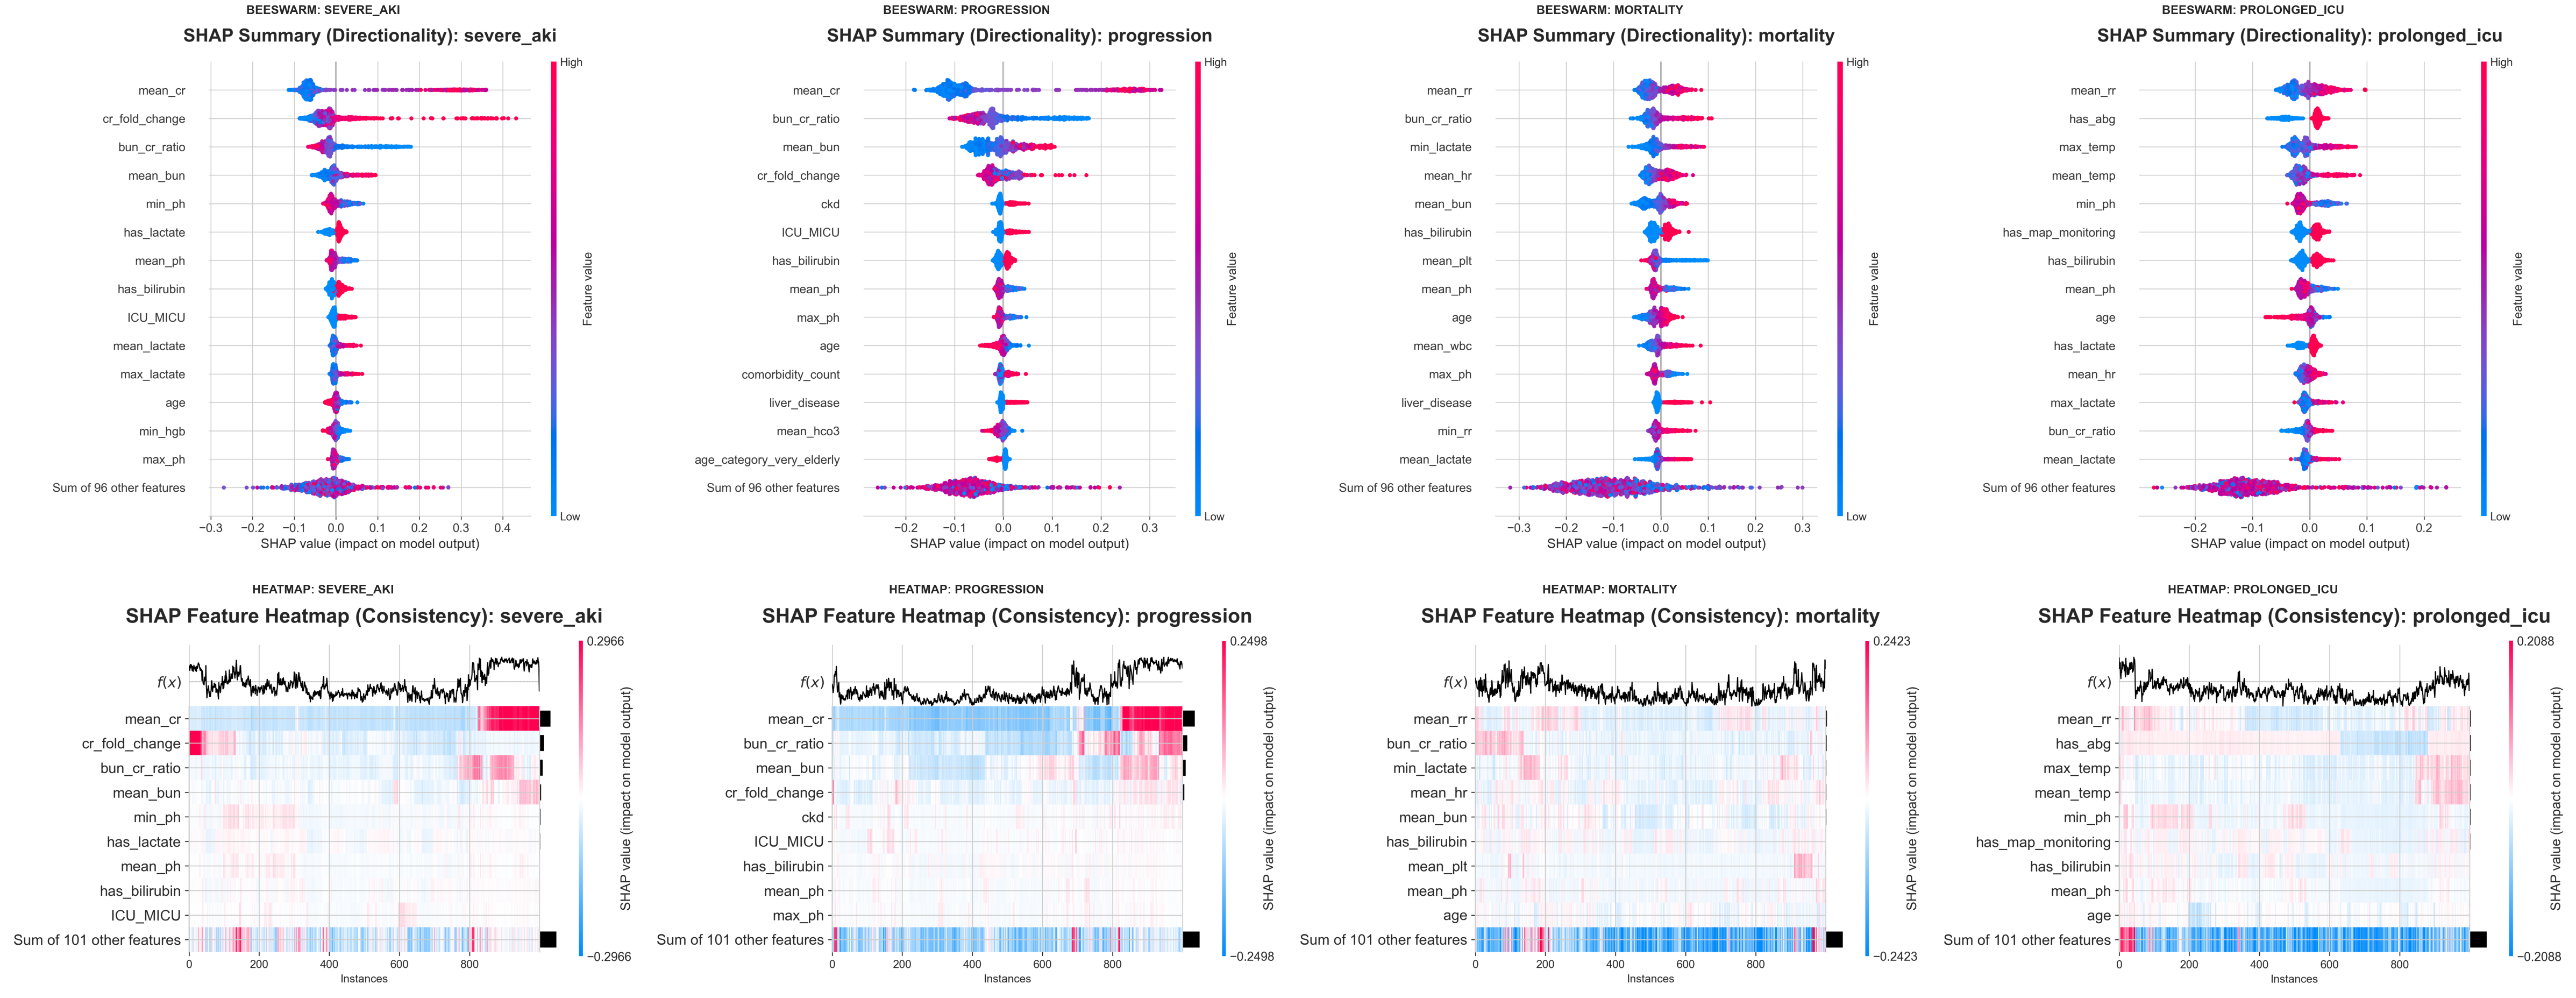


✅ Display complete!


In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Create grid: 2 rows (plot types) × 2 cols (targets)
n_targets = len(target_cols)
n_rows = 2  # Row 0: beeswarm, Row 1: heatmap
n_cols = n_targets  # One column per target

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12*n_targets, 20))

# Handle different shapes of axes array
if n_targets == 1:
    axes = axes.reshape(-1, 1)  # Make it 2D: (2, 1)

print(f"📊 Displaying {n_targets} targets × 2 plot types in {n_rows}x{n_cols} grid...\n")

# Row 0: Beeswarm plots
print("🔹 Loading beeswarm plots...")
for idx, target_name in enumerate(target_cols):
    img_path = f'./output/interpretation/beeswarm_{target_name}.png'
    
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        axes[0, idx].imshow(img)  # Row 0, column idx
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f'BEESWARM: {target_name.upper()}', fontsize=16, fontweight='bold', pad=10)
        print(f"  ✅ Loaded beeswarm for {target_name}")
    else:
        axes[0, idx].text(0.5, 0.5, f'File not found:\n{img_path}', 
                          ha='center', va='center', fontsize=12)
        axes[0, idx].axis('off')
        print(f"  ⚠️  File not found: {img_path}")

# Row 1: Heatmap plots
print("\n🔹 Loading heatmap plots...")
for idx, target_name in enumerate(target_cols):
    img_path = f'./output/interpretation/heatmap_{target_name}.png'
    
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        axes[1, idx].imshow(img)  # Row 1, column idx
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f'HEATMAP: {target_name.upper()}', fontsize=16, fontweight='bold', pad=10)
        print(f"  ✅ Loaded heatmap for {target_name}")
    else:
        axes[1, idx].text(0.5, 0.5, f'File not found:\n{img_path}', 
                          ha='center', va='center', fontsize=12)
        axes[1, idx].axis('off')
        print(f"  ⚠️  File not found: {img_path}")

plt.tight_layout()
plt.show()

print("\n✅ Display complete!")

## 6. Save Results

In [12]:
print("SAVING FINAL RESULTS")
print("="*60)

# Save predictions
predictions_df = pd.DataFrame(best_pred, columns=[f'{col}_pred_proba' for col in target_cols])
predictions_df = pd.concat([y_test.reset_index(drop=True), predictions_df], axis=1)
predictions_df.to_csv(f"{DATA_DIR}/best_model_predictions_test.csv", index=False)
print(f"✓ Predictions saved to {DATA_DIR}/best_model_predictions_test.csv")

# Save best model identifier
with open(f"{MODEL_DIR}/best_model_name.txt", 'w') as f:
    f.write(best_model_name)
print(f"✓ Best model name saved to {MODEL_DIR}/best_model_name.txt")

SAVING FINAL RESULTS
✓ Predictions saved to ./prediction_output/data/best_model_predictions_test.csv
✓ Best model name saved to ./prediction_output/result/models/best_model_name.txt


In [ ]:
# ============================================================
# COMPLETION
# ============================================================
print("\n" + "="*70)
print("✅ MODEL TRAINING COMPLETE!")
print("="*70)
print(f"\n📁 Output files created:")
print(f"   Models:")
print(f"     - {MODEL_DIR}/logistic_regression.pkl")
print(f"     - {MODEL_DIR}/lr_best_params.pkl")
print(f"     - {MODEL_DIR}/random_forest.pkl")
print(f"     - {MODEL_DIR}/rf_best_params.pkl")
print(f"     - {MODEL_DIR}/xgb_models.pkl")
print(f"     - {MODEL_DIR}/xgb_best_params.pkl")
print(f"     - {MODEL_DIR}/mlp.pkl")
print(f"     - {MODEL_DIR}/mlp_best_params.pkl")
print(f"     - {MODEL_DIR}/best_model_name.txt")
print(f"\n   Results:")
print(f"     - model_comparison.csv")
print(f"     - best_model_predictions_test.csv")
print(f"     - rf_feature_importance.csv")
print(f"     - xgb_feature_importance.csv")
print(f"\n   Visualizations:")
print(f"     - ROC curves (all models)")
print(f"     - PR curves (all models)")
print(f"     - Feature importance plots")
print(f"     - model_comparison_plot.png")
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test ROC-AUC: {comparison_df.loc[best_idx, 'Test_ROC_AUC']:.4f}")
print(f"\n🎯 All models were hyperparameter-tuned using validation set!")
print("="*70)


✅ MODEL TRAINING COMPLETE!

📁 Output files created:
   Models:
     - ./prediction_output/result/models/logistic_regression.pkl
     - ./prediction_output/result/models/lr_best_params.pkl
     - ./prediction_output/result/models/random_forest.pkl
     - ./prediction_output/result/models/rf_best_params.pkl
     - ./prediction_output/result/models/xgboost_models.pkl
     - ./prediction_output/result/models/xgb_best_params.pkl
     - ./prediction_output/result/models/mlp.pkl
     - ./prediction_output/result/models/mlp_best_params.pkl
     - ./prediction_output/result/models/best_model_name.txt

   Results:
     - model_comparison.csv
     - best_model_predictions_test.csv
     - rf_feature_importance.csv
     - xgb_feature_importance.csv

   Visualizations:
     - ROC curves (all models)
     - PR curves (all models)
     - Feature importance plots
     - model_comparison_plot.png

🏆 Best Model: Random Forest (Tuned)
   Test ROC-AUC: 0.8476

🎯 All models were hyperparameter-tuned using 